# Earthdata Archive Data Tests

**Goal**
<br/>
To use the MUR 1-km dataset stored in Earthdata Archive in conjunction with the MUR Climatology dataset (created by Mike Chin and cleaned in the notebook 'CleaningMURClimatologyData.ipynb') to create a Sea Surface Temperature (SST) anomaly dataset for use in testing runtimes on dataset loading and plotting applications. 

**Run Location**
<br/>
This notebook was run on an AWS EC2 t3.medium instance. It was also successfully run on a t3.small instance.

**Dataset**
<br/>
MUR 1-km L4 SST netCDF4 On-Premise https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/

### Import Modules

In [48]:
%matplotlib inline
from netCDF4 import Dataset
from urllib import request, parse
from platform import system
from os.path import join, expanduser, basename
from getpass import getpass
from netrc import netrc
from http.cookiejar import CookieJar
import numpy as np
import xarray as xr
import dask
import requests
import json
import os
import timeit

### Save Shortname

In [2]:
SHORTNAME = 'MUR-JPL-L4-GLOB-v4.1'

### Set the CMR, URS, and Harmony Endpoints
<br/>
CMR, or the Earthdata Common Metadata Repository, is a high-performance, high-quality, continuously evolving metadata system that catalogs Earth Science data and associated service metadata records. URS is the Earthdata login system, that allows (free) download access to Earthdata data. Harmony API allows you to seamlessly analyze Earth observation data from different NASA data centers.

In [3]:
cmr = "cmr.earthdata.nasa.gov"
urs = "urs.earthdata.nasa.gov"
harmony = "harmony.earthdata.nasa.gov"

cmr, urs, harmony

('cmr.earthdata.nasa.gov',
 'urs.earthdata.nasa.gov',
 'harmony.earthdata.nasa.gov')

### Earthdata Login
<br/>
An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

The setup_earthdata_login_auth function will allow Python scripts to log into any Earthdata Login application programmatically. To avoid being prompted for credentials every time you run and also allow clients such as curl to log in, you can add the following to a .netrc (_netrc on Windows) file in your home directory:

    machine urs.earthdata.nasa.gov
    login <your username>
    password <your password>

Make sure that this file is only readable by the current user or you will receive an error stating "netrc access too permissive."

    $ chmod 0600 ~/.netrc

In [4]:
TOKEN_DATA = ("<token>"
              "<username>%s</username>"
              "<password>%s</password>"
              "<client_id>PODAAC CMR Client</client_id>"
              "<user_ip_address>%s</user_ip_address>"
              "</token>")


def setup_earthdata_login_auth(urs: str='urs.earthdata.nasa.gov', cmr: str='cmr.earthdata.nasa.gov'):

    # GET URS LOGIN INFO FROM NETRC OR USER PROMPTS:
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(urs)
        print("# Your URS credentials were securely retrieved from your .netrc file.")
    except (FileNotFoundError, TypeError):
        print('# Please provide your Earthdata Login credentials for access.')
        print('# Your info will only be passed to %s and will not be exposed in Jupyter.' % (urs))
        username = input('Username: ')
        password = getpass('Password: ')

    # SET UP URS AUTHENTICATION FOR HTTP DOWNLOADS:
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, urs, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

    # GET TOKEN TO ACCESS RESTRICTED CMR METADATA:
    ip = requests.get("https://ipinfo.io/ip").text.strip()
    r = requests.post(
        url="https://%s/legacy-services/rest/tokens" % cmr,
        data=TOKEN_DATA % (str(username), str(password), ip),
        headers={'Content-Type': 'application/xml', 'Accept': 'application/json'}
    )
    return r.json()['token']['id']


# Provide URS credentials for HTTP download auth & CMR token retrieval:
_token = setup_earthdata_login_auth(urs=urs, cmr=cmr)

# Your URS credentials were securely retrieved from your .netrc file.


## Setup for Regional Tests

### Period and Region of Interest

In [15]:
start_date = "2019-08-01"
end_date   = "2020-01-20"

minlon = -160
minlat = 18
maxlon = -154
maxlat = 23

### Find Dataset Concept-Id
<br/>
OPeNDAC requires a dataset identifier that we must obtain from the Common Metadata Repository (CMR). In the next cell, submit a request to the CMR to grab the metadata for to the dataset/collection.

In [16]:
mur_results = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': SHORTNAME,
            'token': _token}
).json()

# Select the first/only record in the JSON response:
mur_coll = mur_results['items'][0]

# Select the 'concept-id' from the 'meta' dictionary:
mur_ccid = mur_coll['meta']['concept-id']

mur_ccid

'C1996881146-POCLOUD'

### Find Granule URLs using CMR
<br/>
The next cell joins the base CMR url with the specified subset values in order to find matching granule URLs.

In [17]:
cmr_url = "https://cmr.earthdata.nasa.gov"
req = requests.get(cmr_url + "/search/granules.umm_json?collection_concept_id=" + 
                    mur_ccid + "&temporal=" + start_date + "T09:00:00Z," + end_date + 
                   "T09:00:00Z&pageSize=365&token=" + _token)
response_body = req.json()

Iterate through the CMR response to find OPeNDAP URLs.

In [20]:
od_files = []
for itm in response_body['items']:
    for urls in itm['umm']['RelatedUrls']:
        if 'OPeNDAP' in urls['Description']:
            od_files.append(urls['URL'])

len(od_files)

173

### Subsetting the Data Using OPeNDAP URLs
<br/>
We will specify the desired variables including value ranges in order to subset the data. The subsets will then be downloaded to the local machine. 
<br/>
<br/>
A single increment in value for the latitude and longitude variables represents a change of +0.01 degree. The variables ranges are as follows:

    latitude: 0...17998 (start index: -90)
    longitude: 0...35999 (start index: -180)
    time: 0...0  
    
(This program currently cannot process data at a time scale shorter than 1 day, however, it could be adjusted to do so.)
<br/>
<br/>
This following cell defines converters used to translate the user provided region values from degrees to this dataset's value ranges.

In [21]:
def latcalc(lat):
    if lat == 90:
        lat = 89.99
    if lat == -90:
        lat = -89.99
    return_lat = round((lat * 100) + 8999)
    return str(return_lat)

def loncalc(lon):
    if lon == 180:
        lon = 179.99
    return_lon = round((lon * 100) + 18000)
    return str(return_lon)

In [52]:
start_time = timeit.default_timer()

for f in od_files:
    print ("* Opening --> " + f)
    data_url = f'{f}.dap.nc4'
    
    # The notation below is [start index, step, end index]
    required_variables = {'analysed_sst[0:1:0][' + latcalc(minlat) + ':1:' + latcalc(maxlat) + 
                              '][' + loncalc(minlon) + ':1:' + loncalc(maxlon) + ']',
                          'mask[0:1:0][' + latcalc(minlat) + ':1:' + latcalc(maxlat) + 
                              '][' + loncalc(minlon) + ':1:' + loncalc(maxlon) + ']',
                          'lat[' + latcalc(minlat) + ':1:' + latcalc(maxlat) + ']',
                          'lon[' + loncalc(minlon) + ':1:' + loncalc(maxlon) + ']',
                          'time[0:1:0]'
                         }

    basename = os.path.basename(data_url)
    request_params = {'dap4.ce': ';'.join(required_variables)}
    
    # Identity encoding to work around an issue with server side response compression (??)
    response = requests.get(data_url, params=request_params,  headers={'Accept-Encoding': 'identity'})

    if response.ok:
        with open('../data/MURHawaiiEarthdata/' + basename, 'wb') as file_handler:
            file_handler.write(response.content)
    else:
        print(f'Request failed: {response.text}')

elapsed = timeit.default_timer() - start_time
print(elapsed)

* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190801090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190802090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190803090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190804090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://openda

* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190904090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190905090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190906090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190907090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://openda

* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20191008090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20191009090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20191010090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20191011090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://openda

* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20191111090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20191112090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20191113090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20191114090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://openda

* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20191215090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20191216090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20191217090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20191218090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://openda

* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20200118090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20200119090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20200120090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
1355.1202412660004


### Load Dataset

In [53]:
start_time = timeit.default_timer()


variables=[
    'analysed_sst', 
    'mask'
]

def subset(ds):
    subset_ds = ds[variables]
    return subset_ds

mur_hawaii = xr.open_mfdataset(
    '../data/MURHawaiiEarthdata/*.nc4', 
    preprocess=subset,
    engine='netcdf4',
    combine='by_coords',
    chunks={"time": 30, "lat": 100, "lon": 100}
)


elapsed = timeit.default_timer() - start_time
print(elapsed)

1.9984921190007299


In [25]:
mur_hawaii

,Array,Chunk
Bytes,198.71 MiB,39.06 kiB
Shape,"(173, 501, 601)","(1, 100, 100)"
Count,14705 Tasks,7266 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,198.71 MiB,39.06 kiB
Shape,"(173, 501, 601)","(1, 100, 100)"
Count,14705 Tasks,7266 Chunks
Type,float32,numpy.ndarray


### Add in NAN Values for Land to MUR Data
<br/>
We use the mask dimension to replace temperature values from land observations with NaN so that they are not factored in to our calculations. The mask variable has a value for each coordinate pair representing which surface the temperature was collected from (land, open-sea, ice, etc.).

In [26]:
mur_hawaii_sst = mur_hawaii['analysed_sst'].where(mur_hawaii.mask == 1)

### Convert Temperatures to Celsius
<br/>
The dataset is stored with temperatures measured in Kelvin. This converts it to Celsius for ease of understanding and analysis.

In [27]:
mur_hawaii_sst = mur_hawaii_sst - 273.15

In [28]:
mur_hawaii_sst

,Array,Chunk
Bytes,198.71 MiB,39.06 kiB
Shape,"(173, 501, 601)","(1, 100, 100)"
Count,51208 Tasks,7266 Chunks
Type,float32,numpy.ndarray


### Open MUR Climatology for Hawaii

In [29]:
mur_clim = xr.open_dataarray(
    "../data/MURClimatology.nc", 
    chunks={"time": 30, "lat": 100, "lon": 100}
)

In [30]:
mur_clim

,Array,Chunk
Bytes,420.39 MiB,1.14 MiB
Shape,"(366, 501, 601)","(30, 100, 100)"
Count,547 Tasks,546 Chunks
Type,float32,numpy.ndarray


### Drop the Leap Day

In [33]:
mur_clim = mur_clim.where(mur_clim["time"] != np.datetime64('2004-02-29T09:00:00', 'ns'), drop=True)

### Create Subset

In [34]:
mur_clim_jan = mur_clim[0:20]

In [35]:
mur_clim_subset = mur_clim[212:]

In [36]:
mur_clim_subset = xr.concat([mur_clim_subset, mur_clim_jan], dim="time")

In [37]:
mur_clim_subset = mur_clim_subset.assign_coords({"time": mur_hawaii_sst["time"]})

In [38]:
mur_clim_subset

<xarray.DataArray 'sstclim' (time: 173, lat: 501, lon: 601)>
dask.array<concatenate, shape=(173, 501, 601), dtype=float32, chunksize=(30, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -160.0 -160.0 -160.0 -160.0 ... -154.0 -154.0 -154.0
  * lat      (lat) float32 18.0 18.01 18.02 18.03 ... 22.97 22.98 22.99 23.0
  * time     (time) datetime64[ns] 2019-08-01T09:00:00 ... 2020-01-20T09:00:00
Attributes:
    description:  Hawaii Climatology from 2002-2015.
    start_date:   01/01
    end_date:     12/31
    units:        degC

### Create SST Anomaly Dataset

In [39]:
sst_anomaly = mur_hawaii_sst - mur_clim_subset

In [40]:
sst_anomaly

,Array,Chunk
Bytes,198.38 MiB,38.67 kiB
Shape,"(173, 501, 600)","(1, 100, 99)"
Count,122264 Tasks,12456 Chunks
Type,float32,numpy.ndarray


In [41]:
sst_anomaly = sst_anomaly.chunk({"time": 30, "lat": 100, "lon": 100})

### Find Daily Average Temperature for Time Series

In [42]:
sst_anomaly_mean_ts = sst_anomaly.mean(['lat', 'lon'])

In [43]:
sst_anomaly_mean_ts

<xarray.DataArray (time: 173)>
dask.array<mean_agg-aggregate, shape=(173,), dtype=float32, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-08-01T09:00:00 ... 2020-01-20T09:00:00

### Find Average Temperature for Each Coordinate Pair for Spatial Plot

In [44]:
sst_anomaly_mean_sp = sst_anomaly.mean(['time'])

In [45]:
sst_anomaly_mean_sp

<xarray.DataArray (lat: 501, lon: 600)>
dask.array<mean_agg-aggregate, shape=(501, 600), dtype=float32, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -160.0 -160.0 -160.0 -160.0 ... -154.0 -154.0 -154.0
  * lat      (lat) float32 18.0 18.01 18.02 18.03 ... 22.97 22.98 22.99 23.0

## Regional Tests

### Regional SST Anomaly Averaged Time Series, August 2019 - January 2020

30.88919704900036


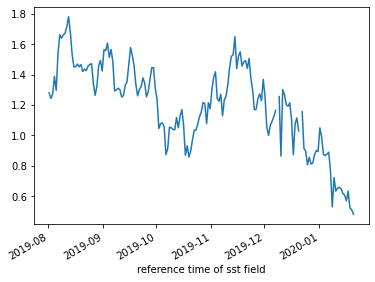

In [49]:
start_time = timeit.default_timer()

sst_anomaly_mean_ts.plot()

elapsed = timeit.default_timer() - start_time
print(elapsed)

### Regional SST Anomaly Averaged Spatial Plot, August 2019 - January 2020

/home/ec2-user/miniconda3/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


108.43337842500023


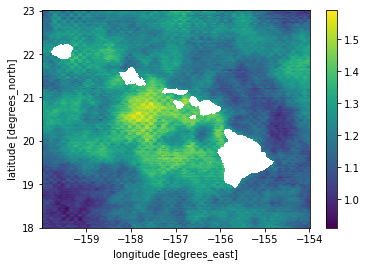

In [50]:
start_time = timeit.default_timer()

sst_anomaly_mean_sp.plot()

elapsed = timeit.default_timer() - start_time
print(elapsed)